# Phase Correlation

Phase correlation says that, if we calculate the Discrete Fourier Transform of two images $f$ and $h$:

$$ F = \mathcal{F}(f); $$$$ H = \mathcal{F}(h) $$

And then we calculate the correlation $R$ of the transforms:
$$ R = \dfrac{F H^*}{|F H^*|} $$

Then, we apply the inverse transform to $R$
$$ g = \mathcal{F}^{-1}(R) $$

The translation between the two images can be found by doing:
$$ (row, col) = arg max\{g\} $$

## Identifying the translation between 2 images

1. Calculate the Fourier Transform of the 2 images you want to compare;
2. Calculate phase correlation using the *phasecorr* function
3. Find the maximum point of the resulting correlation map

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from numpy.fft import *
import sys,os



Text(0.5, 1.0, 'translated Image')

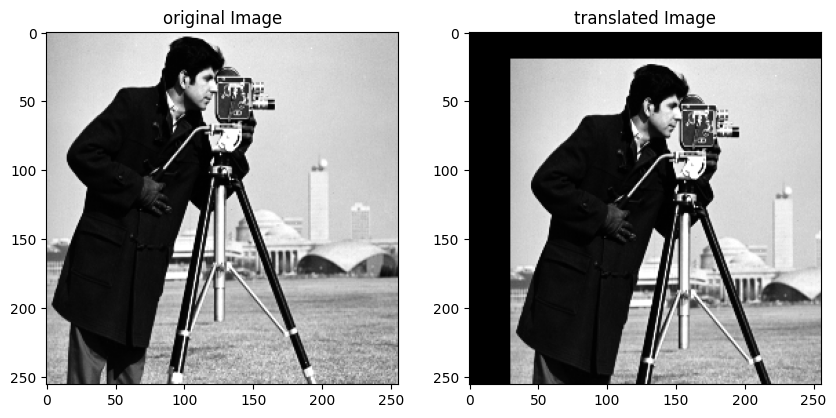

In [2]:
f = mpimg.imread('../figures/cameraman.tif')

# Translating the image to (x,y)
x = 20
y = 30

#f_trans = ia.ptrans(f,(20,30))
f_trans = np.zeros(f.shape)
f_trans[x:,y:] = f[:-x,:-y]

plt.figure(1,(10,10))
plt.subplot(1,2,1)
plt.imshow(f, cmap='gray')
plt.title('original Image')

plt.subplot(1,2,2)
plt.imshow(f_trans, cmap='gray')
plt.title('translated Image')

In [4]:
def phasecorr(f,h):
    F = np.fft.fftn(f)
    H = np.fft.fftn(h)
    T = F * np.conjugate(H)
    R = T/np.abs(T)
    g = np.fft.ifftn(R)
    return g.real

In [5]:
# Calculating phase correlation
g = phasecorr(f,f_trans)

# Finding the point of maximum correlation
i = np.argmax(g)
row,col = np.unravel_index(i,g.shape)
v = np.array(f.shape) - np.array((row,col))
print('Point of maximum correlation: ',v)

Point of maximum correlation:  [20 30]


Text(0.5, 1.0, 'Point of maximum correlation marked (in black)')

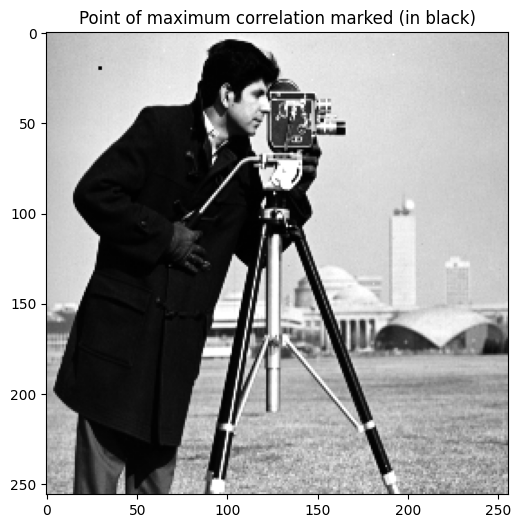

In [6]:
plt.figure(2,(6,6))
f[v[0]-1:v[0]+1,v[1]-1:v[1]+1] = 0
plt.imshow(f, cmap='gray')
plt.title('Point of maximum correlation marked (in black)')

## Identifying rotation between 2 images

1. Calculate the Fourier Transform of the 2 images you want to compare;
2. Convert the obtained images to polar coordinates
3. Calculate phase correlation using the *phasecorr* function
4. Find the maximum point of the resulting correlation map

In [9]:
def affine(f,T,domain=0): 

    if np.sum(domain) == 0: 
        domain = f.shape
        n = f.size
    if len(f.shape) == 2:
        H,W = f.shape
        y1,x1 = np.indices(domain)

        yx1 = np.array([ y1.ravel(), 
                         x1.ravel(), 
                         np.ones(n)])
        yx_float = np.linalg.inv(T).dot(yx1)
        yy = np.rint(yx_float[0]).astype(int)
        xx = np.rint(yx_float[1]).astype(int)

        y = np.clip(yy,0,H-1).reshape(domain)
        x = np.clip(xx,0,W-1).reshape(domain)

        g = f[y,x]

    if len(f.shape) == 3: 
        D,H,W = f.shape 
        z1,y1,x1 = np.indices(domain)
        zyx1 = np.array([ z1.ravel(), 
                          y1.ravel(), 
                          x1.ravel(), 
                          np.ones(n)])
        zyx_float = np.linalg.inv(T).dot(zyx1)

        zz = np.rint(zyx_float[0]).astype(int)
        yy = np.rint(zyx_float[1]).astype(int)
        xx = np.rint(zyx_float[2]).astype(int)

        z = np.clip(zz, 0, D-1).reshape(domain) #z
        y = np.clip(yy, 0, H-1).reshape(domain) #rows
        x = np.clip(xx, 0, W-1).reshape(domain) #columns

        g = f[z,y,x]

    return g

Text(0.5, 1.0, 'Image rotated')

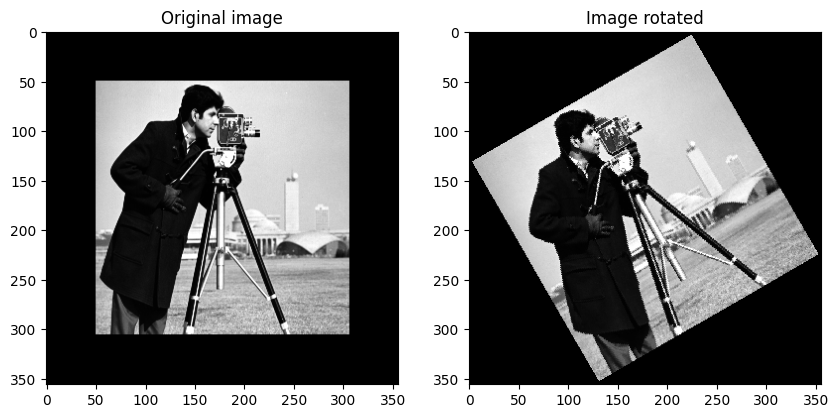

In [10]:
f = mpimg.imread('../figures/cameraman.tif')

# Inserting a border of zeros to allow image rotation
t = np.zeros(np.array(f.shape)+100,dtype=np.uint8)
t[50:f.shape[0]+50,50:f.shape[1]+50] = f
f = t
    
t1 = np.array([
             [1,0,-f.shape[0]/2.],
             [0,1,-f.shape[1]/2.],
             [0,0,1]]);

t2 = np.array([
             [1,0,f.shape[0]/2.],
             [0,1,f.shape[1]/2.],
             [0,0,1]]);

# Rotating the image 30 degrees
theta = np.radians(30)
r1 = np.array([
        [np.cos(theta),-np.sin(theta),0],
        [np.sin(theta),np.cos(theta),0],
        [0,0,1]]);
    
T = t2.dot(r1).dot(t1)
f_rot = affine(f,T,0)

plt.figure(1,(10,10))
plt.subplot(1,2,1)
plt.imshow(f, cmap='gray')
plt.title('Original image')

plt.subplot(1,2,2)
plt.imshow(f_rot, cmap='gray')
plt.title('Image rotated')

In [12]:

def interpollin(f, pts):
    # f - one, two or three dimention array
    # pts - array of points to interpolate:
    # throws IndexError if there are indices out of range in pts
    #from iainterpollin import iainterpollin1D, iainterpollin2D, iainterpollin3D
    f = f.astype(float)
    if f.ndim == 1:
        return interpollin1D(f, np.ravel(pts))
    if f.ndim == 2:
        return interpollin2D(f, pts)
    if f.ndim == 3:
        return interpollin3D(f, pts)


# In[2]:

def interpollin1D(f, pts):
    # f - one dimention array
    # pts - array of points to interpolate:
    # throws IndexError if there are indices out of range in pts
    import numpy as np

    # integer indices
    ipts = np.floor(pts).astype(int)

    # fractional indices
    fpts = pts - ipts

    # workaround for the case some index equals the last valid index
    fpts[ipts>=f.shape[0]-1] += 1
    ipts[ipts>=f.shape[0]-1] -= 1

    I = ipts.copy()
    Ix = ipts.copy()+1

    a = f[I]
    b = f[Ix] - a

    return a + b*fpts


# In[3]:

def interpollin2D(f, pts):
    # f - bi-dimentional image
    # pts - array (2xN) of points to interpolate:
    # throws IndexError if there are indices out of range in pts
    # let's consider x the first and y the second dimention
    import numpy as np

    # integer indices
    ipts = np.floor(pts).astype(int)

    # fractional indices
    fpts = pts - ipts

    # workaround for the case some index equals the last valid index in the respective dimension
    fpts[0][ipts[0]>=f.shape[0]-1] += 1
    ipts[0][ipts[0]>=f.shape[0]-1] -= 1
    fpts[1][ipts[1]>=f.shape[1]-1] += 1
    ipts[1][ipts[1]>=f.shape[1]-1] -= 1

    I = ipts.copy()
    Ix = ipts.copy()
    Ix[0] += 1
    Iy = ipts.copy()
    Iy[1] += 1
    Ixy = Ix.copy()
    Ixy[1] += 1

    a = f[I[0], I[1]]
    b = f[Ix[0], Ix[1]] - a
    c = f[Iy[0], Iy[1]] - a
    e = f[Ixy[0], Ixy[1]] - a - b - c

    return a + b*fpts[0] + c*fpts[1] + e*fpts[0]*fpts[1]


# In[4]:

def interpollin3D(ff, pts):
    # ff - tri dimentional image
    # pts - array (3xN) of points to interpolate:
    # throws IndexError if there are indices out of range in pts
    # let's consider x the first dimension, y the second and z the third
    import numpy as np

    # integer indices
    ipts = np.floor(pts).astype(int)

    # fractional indices
    fpts = pts - ipts

    # workaround for the case some index equals the last valid index in the respective dimension
    fpts[0][ipts[0]>=ff.shape[0]-1] += 1
    ipts[0][ipts[0]>=ff.shape[0]-1] -= 1
    fpts[1][ipts[1]>=ff.shape[1]-1] += 1
    ipts[1][ipts[1]>=ff.shape[1]-1] -= 1
    fpts[2][ipts[2]>=ff.shape[2]-1] += 1
    ipts[2][ipts[2]>=ff.shape[2]-1] -= 1

    I = ipts.copy()
    Ix = ipts.copy()
    Ix[0] += 1
    Iy = ipts.copy()
    Iy[1] += 1
    Iz = ipts.copy()
    Iz[2] += 1
    Ixy = Ix.copy()
    Ixy[1] += 1
    Ixz = Ix.copy()
    Ixz[2] += 1
    Iyz = Iy.copy()
    Iyz[2] += 1
    Ixyz = Ixy.copy()
    Ixyz[2] += 1

    a = ff[I[0], I[1], I[2]]
    b = ff[Ix[0], Ix[1], Ix[2]] - a
    c = ff[Iy[0], Iy[1], Iy[2]] - a
    d = ff[Iz[0], Iz[1], Iz[2]] - a
    e = ff[Ixy[0], Ixy[1], Ixy[2]] - a - b - c
    f = ff[Ixz[0], Ixz[1], Ixz[2]] - a - b - d
    g = ff[Iyz[0], Iyz[1], Iyz[2]] - a - c - d
    h = ff[Ixyz[0], Ixyz[1], Ixyz[2]] - a - b - c - d - e - f - g

    return a + b*fpts[0] + c*fpts[1] + d*fpts[2] + e*fpts[0]*fpts[1] +                f*fpts[0]*fpts[2] + g*fpts[1]*fpts[2] + h*fpts[0]*fpts[1]*fpts[2]



In [19]:
def polar(f, domain, thetamax = 2 * np.pi):
    
    m,n = f.shape
    dm,dn = domain
    Ry,Rx = np.floor(np.array(f.shape)/2)

    b = min(Ry,Rx)/dm
    a = thetamax/dn

    y,x = np.indices(domain)

    XI = Rx + (b*y)*np.cos(a*x)
    YI = Ry + (b*y)*np.sin(a*x)

    g = interpollin(f, np.array([YI.ravel(), XI.ravel()]))
    g = f[YI.astype(np.int16),XI.astype(np.int16)]
    g.shape = domain                

    return g


Text(0.5, 1.0, 'Image rotated (polar coordinate)')

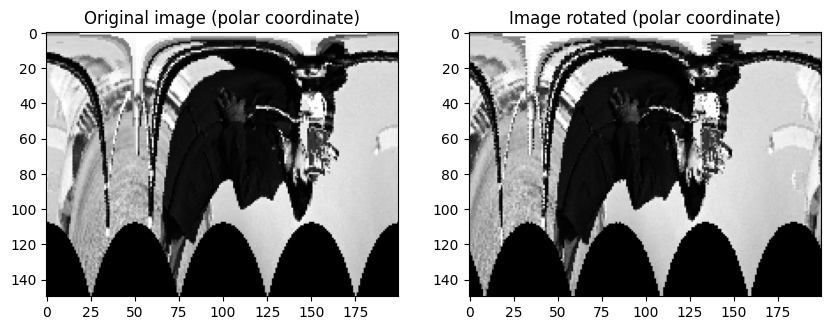

In [21]:
W,H = f.shape
f_polar = polar(f,(150,200),2*np.pi)
f_rot_polar = polar(f_rot,(150,200),2*np.pi)

plt.figure(1,(10,10))
plt.subplot(1,2,1)
plt.imshow(f_polar, cmap='gray')
plt.title('Original image (polar coordinate)')

plt.subplot(1,2,2)
plt.imshow(f_rot_polar, cmap='gray')
plt.title('Image rotated (polar coordinate)')

In [22]:
# Calculating phase correlation
g = phasecorr(f_polar,f_rot_polar)

# Finding the point of maximum correlation
i = np.argmax(g)
corr = np.unravel_index(i,g.shape)

# Calculate the angle
ang = (float(corr[1])/g.shape[1])*360
print('Point of maximum correlation: ',ang)

Point of maximum correlation:  30.6


### Links

- [Conversion function for polar coordinates](../src/polar.ipynb)
- [Phase correlation function](../src/phasecorr.ipynb)